# Scalable Thompson Sampling using Sparse Gaussian Process Models

In our other [Thompson sampling notebook](thompson_sampling.pct.py) we demonstrate how to perform batch optimization using a traditional implementation of Thompson sampling that samples exactly from an underlying Gaussian Process surrogate model. Unfortunately, this approach incurs a large computational overhead that scales polynomially with the optimization budget and so cannot be applied to settings with larger optimization budgets, e.g. those where large batches (>>10) of points can be collected.

Luckily, Trieste also supports a scalable formulation of Thompson sampling. In particular, by coupling a sparse Gaussian process surrogate model with an approximate sampling scheme we can apply Thompson sampling over very large  optimization budgets and batch sizes, i.e. for those settings where standard BO methods are infeasbible. The implementation in this notebook follows our paper (see <cite data-cite="vakili2021scalable"/>)


(https://arxiv.org/pdf/2006.05356.pdf).

In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(1793)
tf.random.set_seed(1793)

## Define the problem and model

We'll use a continuous bounded search space, and build a noisy observer. We then collect an initial design of 15 random points. In order to build a toy problem that requires a large optimization budget, we have contaminated our observations with a large amount of Gaussian noise.

In [2]:
import trieste
from trieste.objectives import (
    hartmann_6,
    HARTMANN_6_MINIMUM,
    HARTMANN_6_SEARCH_SPACE,
)
from trieste.types import TensorType

search_space = HARTMANN_6_SEARCH_SPACE


def noisy_hartmann_6(
    x: TensorType,
) -> TensorType:  # contaminate observations with Gaussian noise
    return hartmann_6(x) + tf.random.normal([len(x), 1], 0, 1, tf.float64)


num_initial_data_points = 15
initial_query_points = search_space.sample(num_initial_data_points)
observer = trieste.objectives.utils.mk_observer(noisy_hartmann_6)
initial_data = observer(initial_query_points)

We'll use a sparse Gaussian process regression to model the function, as implemented in GPflow. The GPflow models cannot be used directly in our Bayesian optimization routines, so we build a GPflow's `SVGP` model using Trieste's convenient model build function `build_svgp` and pass it to the `SparseVariational` wrapper. Note that we also define a `KMeansInducingPointSelector` selector, i.e. we reallocate the 50 inducing points of our `SVGP` model at the start of each BO step to be the centroids of a k-means clustering of the observations. As the optimization progresses, observations are likely to be concentrated in the optimal regions, so clustering provides “targeted” inducing points for BO.

In [3]:
from trieste.models.gpflow import (
    SparseVariational,
    build_svgp,
    KMeansInducingPointSelector,
)
from trieste.models.optimizer import BatchOptimizer

gpflow_model = build_svgp(
    initial_data, search_space, likelihood_variance=0.01, num_inducing_points=50
)

inducing_point_selector = KMeansInducingPointSelector(search_space)

model = SparseVariational(
    gpflow_model,
    num_rff_features=1_000,
    inducing_point_selector=inducing_point_selector,
    optimizer=BatchOptimizer(
        tf.optimizers.Adam(0.1), max_iter=100, batch_size=50, compile=True
    ),
)

## Create the Thompson sampling acquisition rule

Thompson sampling chooses query points as the minimizers of random samples from the model of our objective
function.

Using a [decoupled sampling scheme](https://arxiv.org/abs/2002.09309), we can build approximate samples from our sparse GP surrogate model at low cost. As we can cheaply evaluate the values and gradients of these approximate samples at any point across the search space, our acquisition function optimizers can be used to find the minimizers of the samples across the whole search space. We can increase the quality of these approximate samples at the expense of computational cost by increasing `num_rff_features` (as specified when defining our model above).

We either build batches element by element with `GreedyContinuousThompsonSampling` or allocate a whole batch at once with `ParallelContinuousThompsonSampling`. The latter is faster but has a much higher memory usage. Memory usage can be controlled using `split_acquisition_function_calls` utility, which limits the number of individual evaluations that can be made in parallel (in our case we set this to 100_000).

In [4]:
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.acquisition import ParallelContinuousThompsonSampling
from trieste.acquisition.optimizer import automatic_optimizer_selector
from trieste.acquisition.utils import split_acquisition_function_calls

num_query_points = 100

acq_rule = EfficientGlobalOptimization(
    builder=ParallelContinuousThompsonSampling(),
    num_query_points=num_query_points,
    optimizer=split_acquisition_function_calls(
        automatic_optimizer_selector, split_size=100_000
    ),
)

## Run the optimization loop

Once the optimization loop is complete, the optimizer will return `num_query_points` new query points for every step in the loop. With only five steps, that's already five hundred points!

In [5]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

num_steps = 5
result = bo.optimize(
    num_steps, initial_data, model, acq_rule, track_state=False
)
dataset = result.try_get_final_dataset()

Optimization completed without errors


## Visualising the result

By plotting the regret achieved by the algorithm, we see the convergence over five BO steps after the initial design (denoted by a vertical line and cross). At least one element from each batch of evaluations (dots) achieves better objective values than its predecessor. The evolution of the best solution is highlighted with an orange line.

Text(0.5, 0, '# evaluations')

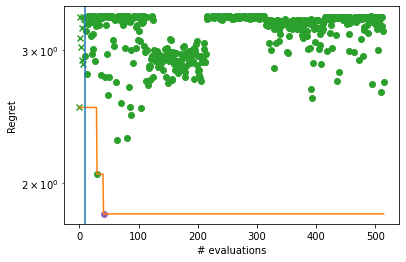

In [6]:
from util.plotting import plot_regret
from matplotlib import pyplot as plt

ground_truth_regret = hartmann_6(dataset.query_points) - HARTMANN_6_MINIMUM
best_found_truth_idx = tf.squeeze(tf.argmin(ground_truth_regret, axis=0))

fig, ax = plt.subplots()
plot_regret(
    ground_truth_regret.numpy(), ax, num_init=10, idx_best=best_found_truth_idx
)

ax.set_yscale("log")
ax.set_ylabel("Regret")
ax.set_xlabel("# evaluations")

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)